# Rainfall prediction assignment report
*by Giulia Martini*

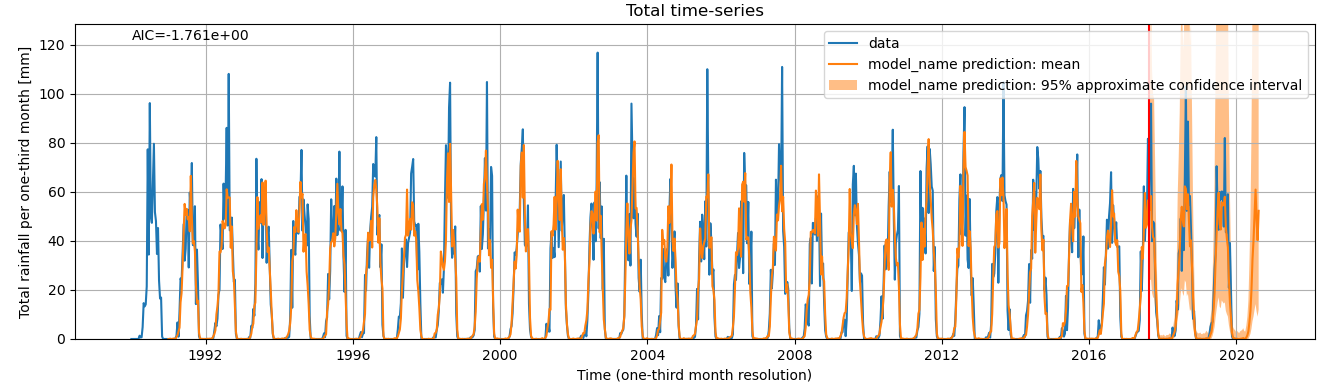

In [4]:
from IPython.display import display, Image

i = Image(filename='../docs/cover_image.png'); i

# Introduction

## Motivation

>Rainfall is an important factor affecting people's livelihoods: if it deviates from the season's averages it can impact agricultural production. Rainfall therefore is an important data stream that we use in WFP to monitor food security.

## Problem statement

The task is to create and fit a model(s) that predicts rainfall in a given region given historical rainfall estimates.
The model should be able to predict the three one-third month intervals per region following the latest data point in the database.

## Data

A dataset is provided with rainfall estimates in a number of regions worldwide indexed by region (`AdminCode`), year, month and decade (= one-third duration of a month).

## Approach

The following high level modelling approaches are applicable to rainfall prediction:

1. purely data driven (no physics (mechanistic) based models and/or considerations are involved);
2. largely physics drive (mechanistic), i.e. the classical scientific approach;
3. the combination of the two.

Although the underlying physics of cloud formation and water circulation is sufficiently well understood to allow for physics based modelling, the data available to use prohibit such an approach. This is because we have only access to region IDs (`AdminCode`) but not to the names of the regions that would allow for the identification of the geographical region and its climate.


## Methods and tools

### A cursory overview of potential method

Our task is a univariate time-series prediction task. It falls into the category of regression problems that is part of the class of supervised learning methods in machine learning.

* Statistical methods:
    - AR
    - ARIMA
    - SARIMAX
    - ...

* Machine learning methods:
    - LSTM
    - RNN
    - gardient boosting
    - random forest
    
We have only 24 hours so only an exploratory analysis is possible, for that a model that is fast to fit is

* statistic based approach in order to be able to provide rigorous uncertianty estimates of the predictions
* each region is treated separately as they are not given with their names (an idea is outlined at the end of this notebook for considering multiple or even all regions together in one model).

Based on these considerations, **autoregression models** are considered for this assignment, in particular the Python library `statsmodels` is used.


# The repository and notebook

### General notes

We decided to create an entire dedicated git repository for the package as although plain Jupyter notebooks are great for combining text, code, and visuals, and for communicating results but it is a poor choice for problems that requires considerable programing let alone software development.


**To minimize code repetition and in turn making errors, we do not directly show the source code of all used custom code but you can display the source code of any function (we mostly use functions) by using ``?? <name_of_the_function>`` in a command cell.**

### Installation

Clone the repository and install the package locally by executing the commands below (run from the root of the repository):

Install all required packages (without `jupyterlab`):

```cmd
pip install -e .
```

Install all required packages (with `jupyterlab`):

```cmd
pip install -e .[jupyterlab]
```

# Analysis

## Data preparation

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

from wfp_giuli.prepare_data import fetch_and_pre_process_data

%matplotlib inline

To see the source code of the imported custom function run the cell below:

In [6]:
?? fetch_and_pre_process_data

If later you would like to see the source of any custom function, you can use the same method or you can directly open the py files in the repository.

Let's run the imported function (it take a few minutes but has to be perfomed only once). It performs the following tasks:

* fetches the rainfall data from the [provided URL](https://wfp-public.oss-eu-central-1.aliyuncs.com/tmp/rainfall_by_country.csv);
* compiles a single `pandas` dataframe with all the data;
* negative entries for the `mean_rainfall` variable are interpreted as missing values -> `nan` values;
* checks and removes duplicated rows;
* checks for time series with missing time-stamps -> rows with missing time-stamps are added -> `nan` values for the `mean_rainfall` variable;
* removes regions missing more than 50% of the data;
* saves the `pandas` dataframe containing the post-processed data.

The function outputs:
* a dataset summary table;
* a matrix plot that indicates the missing values.

The saved data will be used for subsequent analysis. The fetching and pre-processing should be rerun only if the hosted online has changed.

c:\users\martinig\desktop\giuli\job_applications\wfp\wfp_giuli\wfp_giuli\prepare_data.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mean_rainfall"][df.mean_rainfall < 0] = float("nan")
c:\users\martinig\desktop\giuli\job_applications\wfp\wfp_giuli\wfp_giuli\prepare_data.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "mean_rainfall"


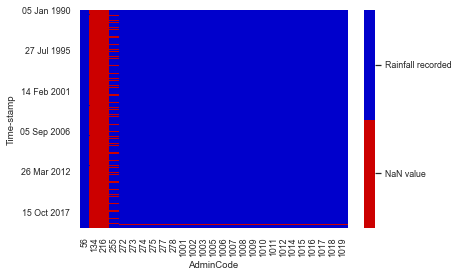

Database summary
-------------------------------------------------------  ---------
Years of observation                                     30
Number of observations per location                      1080
Total number of locations                                245
Number of locations with missing or inconsistent values  27
AdminCodes removed from analysis                         [134 216]


In [7]:
fetch_and_pre_process_data()

As demonstration example, two regions are considered and an autoregression model which takes into account seasonal variations is fit for each region.  If you want to fit a model for a different region, please modify the `region_ids` variable below.

To fit and plot a predictive model a customized function is used.
While running, the function `fit_and_plot_ar_model` print-screens progress information and the optimal lag for each model.
The optimal lag is found in a range of possible lags by an algorithm minimizing the Akaike information criterion.

In [8]:
from wfp_giuli.ar_utils import fit_and_plot_ar_model

In [9]:
region_ids = [102, 1017]

In [10]:
figs = []
for ii, region_id in enumerate(region_ids):
    print(f"region: {ii+1}/{len(region_ids)}")
    fig = fit_and_plot_ar_model(region_id, log_and_shift_transform=False)
    figs.append(fig)

region: 1/2
Optimal lag: 74
region: 2/2
Optimal lag: 38


The data and the model predictions are then plotted.
In the first subplot the original data (blue line) and the model predictions (orange line) for the entire time series are displayed. In the left corner the Akaike information criterion (AIC) for the given model is displayed.
In the second subplot a zoomed view is available.
For both plots:
* The red line indicates the last observation that is used for fitting the model;
* The organge line after the red line shows the model prediction for the following four time-stamps;
* The light-orange band represents the model predicition 95% confidence interval.


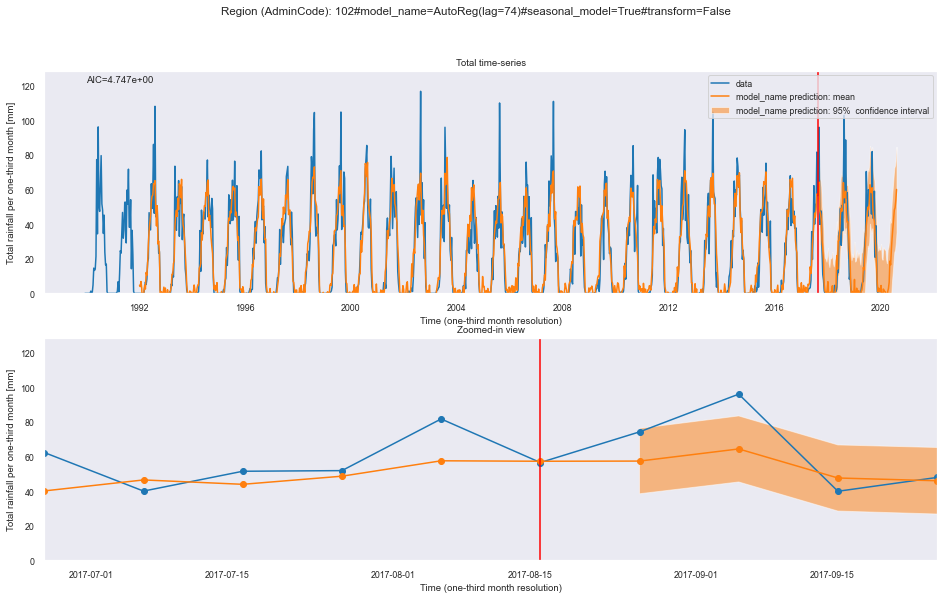

In [11]:
figs[0][0]

Diagnostic plots are also generated to assess the goodness of the model.

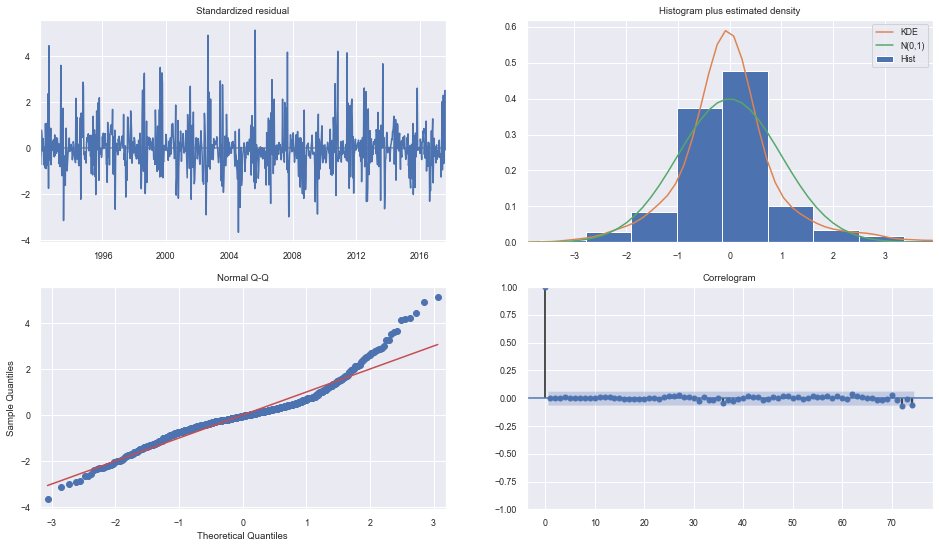

In [12]:
figs[0][1]

To avoid negative model predictions the following transformation is applied:  
$ y_{tr} = log(y + shift) $

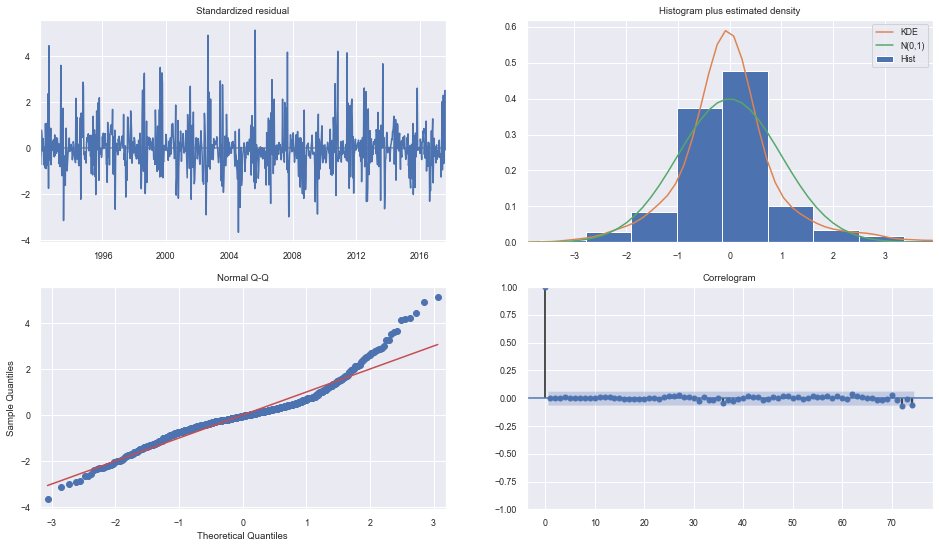

In [13]:
figs[0][1]

Optimal lag: 36


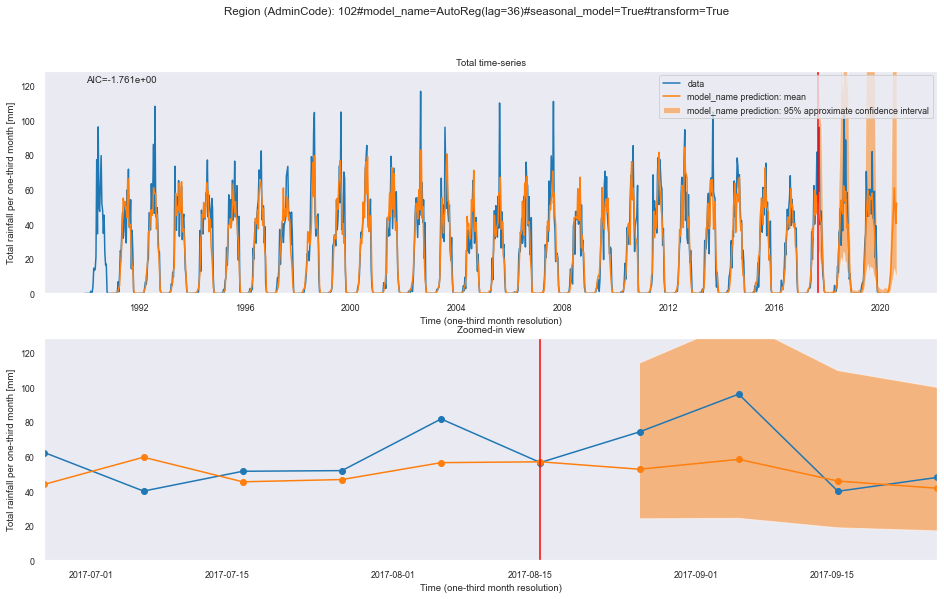

In [14]:
figs = fit_and_plot_ar_model(region_ids[0], log_and_shift_transform=True)

figs[0]

The predictions for the three one-third month intervals per region are then stored in a dataframe.
For the regions in which the time series is incomplete a linear interpolation is performed in order to fit the model.
The time-stamp of the missing values and the interpolated values are automatically screen-printed.

In [15]:
from wfp_giuli.ar_utils import fit_ar_model_and_predict

In [16]:
df_preds = pd.DataFrame()
for ii, region_id in enumerate(region_ids):
    print("-"*50)
    print(f"region id: {region_id}; {ii+1}/{len(region_ids)}")
    df_pred = fit_ar_model_and_predict(region_id=region_id)
    df_preds = df_preds.append(df_pred)


--------------------------------------------------
region id: 102; 1/2
Optimal lag: 36
--------------------------------------------------
region id: 1017; 2/2

Times (index) of missing points with the interpolated values: 
time_stamp_dti_hours
2019-08-28 05:59:59.500    4.218165
2019-09-07 09:59:59.500    3.914541
Freq: 244H, dtype: float64 

Optimal lag: 4


## Ideas for improved modelling

Visual inspection of the results clearly shows that the fit models tend to under-estimate sistematically the maximum values (e.g. AdminCode = 1017).
It should be checked if this behaviour is caused by the logarithmic transformation.

### Adding cross validation
The advised way of performing cross validation with time series is using rolling forecasts.
The method consists in training the model on a small subset of the dataset, make predictions for the later data points and then checking the accuracy of the predictions. At this point the predicted data are used with the first subset as training set and a new model is fit. The subsequent data points are then predicted and their accuracy checked as in the previous step. This procedure should be repeated multiple times in an iterative manner. The picture below shows the described procedure in an intuitive way.
![title](https://i.stack.imgur.com/fXZ6k.png)

### Machine learning regression

Further consideration should be given to the following machine learning approaches that are commonly and successfully applied for time-series prediction in various domains:   

* [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory), e.g. [1](https://www.mdpi.com/2073-4433/10/11/668), [2](https://onlinelibrary.wiley.com/doi/10.1002/dac.3999)  
* [RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network), e.g. [2](https://onlinelibrary.wiley.com/doi/10.1002/dac.3999) 
* [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting), e.g. [2](https://onlinelibrary.wiley.com/doi/10.1002/dac.3999)
    
Note that most machine learning approaches (as those mentioned above) do not come with uncertainty estimation
Conformal prediction could be tried asa rigourous and general approach for uncertainty quantification of machine learning models.

### Additional data

* other measured environmental variables for training on past data
* weather and climate simulation data could used as input for the model

### Incorporation of our physical understanding of the studied system

### Hierachical models

* seach for patterns in the data, e.g. similarity between certain regions might be present, for example, they are close to each other and/or having comparable climatic conditions
* a basic cluster analysis (or other unspervised learning methods) using some statistics of the time series per region could be used as features
* shared parameter between the regions in the same group, e.g. Bayesian hierachical modelling might be used to express in the model the known or found relatedness between regions and in turn time-series.

## Notes on improving the repository

If there is more time available for the development:

* breaking the code into modules and function that follow the conceptual model of the task;
* making functions out of the code snippets used more than once;
* writing unit tests for the majority of the codes;
* add a basic documentation of the API, e.g. using `pdoc3`.

If the code is intended to be used in production and in multiple projects:

* unit testing on multiple OSs and using multiple python versions;
* packaging into a pip installable package;
* more extensive documentation, e.g. `sphinx`.